In [1]:
import numpy as np
import pandas as pd 
from skimage.io import imread, imsave
from skimage import draw
import matplotlib.pyplot as plt
import os
import pdb
import pickle

In [2]:
# Get image names
train = os.listdir('../../data/train')
print(len(train))

104070


In [3]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [4]:
# Load masks
masks = pd.read_csv('../../data/train_ship_segmentations.csv')
print(len(masks))

131030


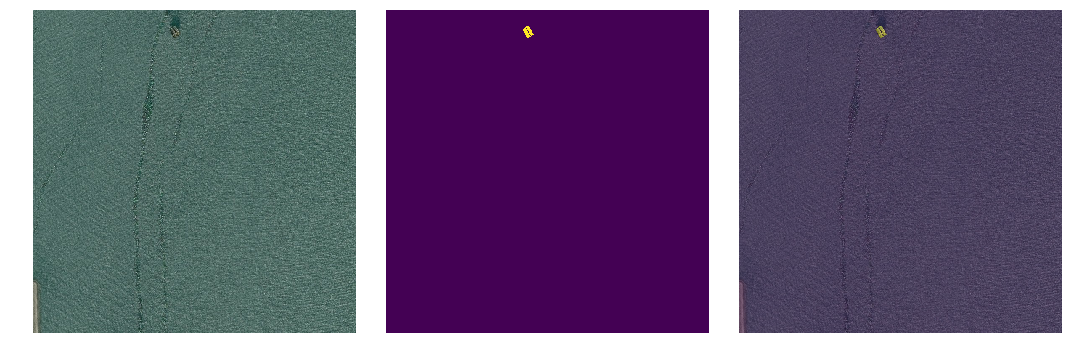

In [5]:
# One example
ImageId = train[3]

img = imread('../../data/train/' + ImageId)
img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

# Take the individual ship masks and create a single mask array for all ships
all_masks = np.zeros((768, 768))
for mask in img_masks:
    all_masks += rle_decode(mask)

fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(all_masks)
axarr[2].imshow(img)
axarr[2].imshow(all_masks, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

In [6]:
def box_to_mask(box,mask_size=(768,768)):
    R0 = box[0]
    C0 = box[1]
    L1 = box[2]
    L2 = box[3]
    theta = box[4]
    R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    box = 0.5*np.array([[L1,L2],[L1,-L2],[-L1,-L2],[-L1,L2]]).T
    box_rot = np.dot(R,box)
    rr, cc = draw.polygon(R0+box_rot[0,:],C0+box_rot[1,:],shape=mask_size)
    mask = np.zeros(mask_size,dtype=int)
    mask[rr,cc] = 1
    return mask

def mask_to_box(mask):
    mask_size = mask.shape[0]
    row_non_zero, col_non_zero = np.nonzero(mask)
    
    ############ Find corner coordinates ###########
    # Note: Because the pixel values are discrete, it will make
    # more sense to start from top-left or top-right depending on the orientation
    # Top coordinate
    min_row = np.min(row_non_zero)
    min_row_idxs = np.where(row_non_zero==min_row)
    top_coord_1 = min_row, np.min(col_non_zero[min_row_idxs])  # top-left
    top_coord_2 = min_row, np.max(col_non_zero[min_row_idxs])  # top-right
    # Bottom coordinate
    max_row = np.max(row_non_zero)
    max_row_idxs = np.where(row_non_zero==max_row)
    bottom_coord_1 = max_row, np.max(col_non_zero[max_row_idxs])  # bottom-right
    bottom_coord_2 = max_row, np.min(col_non_zero[max_row_idxs])  # bottom-left
    # Left coordinate
    min_col = np.min(col_non_zero)
    min_col_idxs = np.where(col_non_zero==min_col)
    left_coord_1 = np.max(row_non_zero[min_col_idxs]), min_col  # left-bottom
    left_coord_2 = np.min(row_non_zero[min_col_idxs]), min_col  # left-top
    # Right coordinate
    max_col = np.max(col_non_zero)
    max_col_idxs = np.where(col_non_zero==max_col)
    right_coord_1 = np.min(row_non_zero[max_col_idxs]), max_col  # right-top
    right_coord_2 = np.max(row_non_zero[max_col_idxs]), max_col  # right-bottom
    # Stack coordinates and draw masks from boxes (polygons)
    rect_coords_1 = np.array([top_coord_1,left_coord_1,bottom_coord_1,right_coord_1])
    rect_coords_2 = np.array([top_coord_2,left_coord_2,bottom_coord_2,right_coord_2])
    rr_1,cc_1 = draw.polygon(rect_coords_1[:,0],rect_coords_1[:,1], shape=None)
    mask1 = np.zeros_like(mask)
    mask1[rr_1,cc_1] = 1
    rr_2,cc_2 = draw.polygon(rect_coords_2[:,0],rect_coords_2[:,1], shape=None)
    mask2 = np.zeros_like(mask)
    mask2[rr_2,cc_2] = 1
    # Whichever polygon mask is closest to raw pixel mask, choose those coordinates
    IOU1 = np.sum(mask & mask1)/np.sum(mask | mask1)
    IOU2 = np.sum(mask & mask2)/np.sum(mask | mask2)
    if IOU1 > IOU2:
        rect_coords = rect_coords_1
    else:
        rect_coords = rect_coords_2 

    ############ Find box parameters ###########
    # Start from box corner which is furthest from borders
    pivot_corner = np.argmax(np.amin(np.minimum(rect_coords, mask_size-rect_coords),axis=1))
    rect_coords = np.roll(rect_coords,-pivot_corner,axis=0)
    # vectors directed towards neighboring corners
    vec1 = rect_coords[1,:]-rect_coords[0,:]
    vec2 = rect_coords[0,:]-rect_coords[3,:]
    # find midpoints from pivot_corner, vec1 and vec2
    midpoint = rect_coords[0,:] + vec1/2 - vec2/2
    # find box lengths
    L1 = np.sqrt(np.sum(np.power(vec1,2))) 
    L2 = np.sqrt(np.sum(np.power(vec2,2))) 
    longer = np.argmax([L1,L2])
    if L1 >= L2:
        vec = vec1 
    else:
        vec = vec2
        L = L1
        L1 = L2
        L2 = L
    # find orientation of longest vec
    theta = np.arctan(vec[1]/vec[0])
    # constrain theta between -45 and 45
    if np.abs(theta) > np.pi/4:
        L = L1
        L1 = L2
        L2 = L
        if theta > np.pi/4:
            theta -= np.pi/2
        else:
            theta += np.pi/2
    # construct box vector
    box = [midpoint[0],midpoint[1],L1,L2,theta]
    return box



In [7]:
save_new_image = True
new_image_directory = '../../data_ships_only/train/'
all_image_ids = []
num_ships = []
box_image_ids = []
R = []
C = []
L1 = []
L2 = []
theta = []
for i, ImageId in enumerate(train):
    if i % 1000 == 0:
        print(i)
    #if i ==  5000:
    #    break
        
    img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()
    if img_masks[0] is np.nan:
        continue
        num_ships.append(0)
        if save_new_image:
            img = imread('../../data/train/' + ImageId)
            imsave(new_image_directory + ImageId,img)
    else:
        all_image_ids.append(ImageId)
        img = imread('../../data/train/' + ImageId)
        if save_new_image:
            imsave(new_image_directory + ImageId,img)
        img_masks = masks.loc[masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()
        num_ships.append(len(img_masks))

        for j in range(len(img_masks)):
            mask = rle_decode(img_masks[j])
            box_vec = mask_to_box(mask)
            box_image_ids.append(ImageId)
            C.append(box_vec[0])  # THIS IS A MISTAKE BUT GO WITH IT
            R.append(box_vec[1])
            L1.append(box_vec[2])
            L2.append(box_vec[3])
            theta.append(box_vec[4])
            if False:
                # construct rotated box for sanity check
                mask = box_to_mask(box_vec)
                img[mask] = 255

                fig, axarr = plt.subplots(1,2,figsize=(12, 6))
                axarr[0].axis('off')
                axarr[0].imshow(img)
                axarr[1].axis('off')
                axarr[1].imshow(mask)
                plt.show()
                pdb.set_trace()

    

0


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/0005d01c8.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/000d42241.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/000fd9827.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/00113a75c.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

1000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/026e583a0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/0282e6975.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/028e081d0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/029377b79.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

2000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/04e255396.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/04eb281b0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/0505379cf.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/050562c13.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

3000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/073ec10a2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/0761de7f3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/076b8dce4.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/077501d84.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

4000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/09b279b69.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/09cc5fd1c.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/09da5f556.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/09ddbdd88.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

5000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/0c1978ecd.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/0c34f132d.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/0c4adc882.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/0c4e30bfd.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

6000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/0ea7ed6af.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/0eabfc974.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/0ec53fa69.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/0ec5dbd9b.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

7000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/10eb5baad.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/10f153420.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/10f5b2da5.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/10f6bb5b1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

8000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/13522033c.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/135906b73.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/136c9e185.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/1371dcfdc.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

9000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/15ce45c8c.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/15d14e5e3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/15d2e8a08.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/15d775515.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

10000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/183f37d19.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/1841ae973.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/1847d9a8f.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/184df115d.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

11000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/1abd998f8.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/1abe750e4.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/1ac673df3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/1ae3c3ddd.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

12000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/1d557aaf5.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/1d6d38c25.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/1d6f7c03d.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/1d7051dd9.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

13000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/1fb2c3fa9.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/1fb90012d.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/1fbd87716.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/1fc060735.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

14000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/22365e9ad.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/224192aec.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/22530ce3e.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/225c28abe.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

15000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/24a3eee13.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/24a5b05f5.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/24b1b1e88.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/24b87a332.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

16000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/2705a988a.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/2709a76f9.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/271581fae.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/27275a2c5.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

17000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/2967b9968.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/297bbd89a.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/298470181.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/2987d54e7.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

18000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/2bf34481c.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/2bf46efbd.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/2c036f7e2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/2c10b281c.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

19000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/2e7afbc47.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/2e7e74b33.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/2e804f988.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/2e8f868b0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

20000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/31107dcd2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/3114c4c17.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/3116afebb.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/312ad7a7b.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

21000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/3398b4f45.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/33a108b58.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/33a7f7318.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/33b258d1e.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

22000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/36304460a.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/3642fc67b.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/365e1c144.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/3663d7d15.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

23000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/389e6ceb4.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/38a429921.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/38a5567b4.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/38af45d7f.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

24000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/3b0c7d3a5.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/3b0f2790a.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/3b1762c70.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/3b3ba491f.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

25000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/3d8bd8ad5.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/3d9a26f9c.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/3d9b3fd1a.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/3daa78b55.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

26000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/4009ee669.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/401b4fa20.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/40255fbab.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/402a1d27f.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

27000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/4265ae790.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/426fc8ad2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/4275d69dd.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/4276f636f.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

28000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/44c3651a2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/44c592564.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/44c7e9889.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/44ce50be1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

29000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/47616c570.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/476e477a6.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/4774d2b3b.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/47761512e.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

30000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/49e338d6a.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/49ea72c58.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/49ee0c6f9.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/49fd215b4.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

31000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/4c6099240.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/4c6969602.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/4c8fdf485.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/4c9084955.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

32000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/4ee08a40e.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/4ee8ac2ec.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/4ef8a02e6.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/4ef9dec1d.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

33000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/51651efcd.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/517e4c350.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/51889c430.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/518bcb890.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

34000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/53b071ac8.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/53b260be4.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/53c60e10f.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/53d40f2a4.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

35000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/56389fabe.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/56592d01f.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/565d51206.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/5666113f2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

36000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/58b4f7cd6.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/58b5fba1c.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/58c5448b3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/58c8f7729.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

37000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/5b36f0a70.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/5b3852205.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/5b4867a4e.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/5b4cf4164.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

38000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/5dbb8b4f0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/5dc05db59.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/5dc7a9413.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/5dc8066b4.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

39000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/60138fdad.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/6015c2c4d.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/601c879b8.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/602c18ec6.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

40000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/626c28137.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/627dd4c06.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/628999cd0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/628bda4f0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

41000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/64eeffe1d.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/64f78480c.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/64fe2b4a3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/6508d2585.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

42000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/67654485a.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/6768e5a9a.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/677099af4.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/67791da86.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

43000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/69cd19665.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/69d4fd710.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/69d971f47.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/69f12a289.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

44000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/6c3d8f0c7.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/6c50ea003.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/6c51b9af1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/6c591a931.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

45000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/6ea7968a5.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/6eb900fff.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/6ebd0b7a0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/6ebd78f48.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

46000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/711324399.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/7116d2c84.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/711b28b4e.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/7120ee0b1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

47000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/739007d1a.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/7391288bc.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/739860678.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/73a323103.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

48000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/75f997d1d.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/76029c4d1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/76185513c.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/7628ad734.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

49000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/78812705c.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/788628d36.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/788c61be2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/788f01cdc.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

50000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/7ae3469fe.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/7aef3b3bd.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/7af315cfe.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/7b00bec95.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

51000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/7d69173a6.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/7d69a5cfe.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/7d70ff644.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/7d8e4f383.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

52000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/7fd3dbab3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/7fd710f1d.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/7fdb698d6.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/7ff596618.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

53000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/823373755.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/8234a8e02.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/824808f58.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/824dbb438.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

54000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/849ed8f7c.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/84ab71602.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/84b1745b0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/84bda1fa3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

55000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/871d71a5b.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/872595e44.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/872cd64f0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/872de369e.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

56000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/89b101ef1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/89bf927ce.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/89c09d2a4.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/89c2ed1d7.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

57000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/8c2a4fb7d.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/8c2adc686.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/8c2bdf97d.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/8c3e4558d.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

58000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/8e984c4a9.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/8e9877587.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/8e9973701.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/8e9f89188.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

59000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/9102f4458.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/910e7f8e2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/9113b5f77.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/9115f80de.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

60000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/937b7d556.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/938aa66a8.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/93a20f5f4.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/93b2fb900.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

61000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/95fe833a7.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/961d46d01.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/9626711c0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/9628a0c0a.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

62000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/9868a54cd.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/9868fff3b.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/98715c706.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/987f8cd6e.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

63000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/9ace38dea.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/9ad8b4ef4.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/9aee6c24f.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/9aee8240b.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

64000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/9d39c37d0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/9d459702a.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/9d517a728.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/9d5b6b548.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

65000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/9fcff0efb.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/9fd828ce8.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/9fdb353bc.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/9ff1491a6.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

66000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/a24fc9845.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/a2600c6fc.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/a263dd6d6.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/a26fecd40.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

67000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/a4d32f6a8.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/a4df95baf.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/a4e6805b5.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/a4e99778e.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

68000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/a7388b62c.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/a738c53f0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/a73ddb46a.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/a74178b5b.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

69000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/a9c8c07bf.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/a9f08b942.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/a9f72bfcc.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/a9fc9bd1e.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

70000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/ac29e3e6c.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/ac30898c3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/ac38a969e.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/ac4b86a71.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

71000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/ae82de419.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/ae8b46252.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/ae95b0536.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/aea0f160a.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

72000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/b1082839f.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/b109cd1a1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/b10baecc6.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/b110009c7.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

73000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/b37d6e239.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/b37e838d9.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/b37f303d5.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/b3808bee9.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

74000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/b5de794fb.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/b5e0ad87c.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/b5f604853.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/b60053cc8.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

75000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/b857c2a3b.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/b873de126.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/b874f9944.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/b8871cb12.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

76000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/badebc021.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/bae10e0fc.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/bae4d9cac.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/bae64b2a1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

77000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/bd6cdb47e.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/bd75465b1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/bd7cde303.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/bd7e19756.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

78000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/bfd9ff1d1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/bfdcdec37.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/bfde5f0d3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/bfece7709.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

79000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/c24deb209.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/c24e3ba28.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/c2576af24.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/c25bcac2e.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

80000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/c4dec483e.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/c4e5e0ef1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/c4e60fbdb.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/c508c3ce1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

81000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/c75653c56.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/c757be473.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/c75b79cf1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/c76ff2f8e.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

82000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/c9d0c547b.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/c9d23a9ab.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/c9ef9957c.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/c9efee725.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

83000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/cc3c36fb1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/cc4150654.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/cc4e59e7c.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/cc5f0651d.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

84000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/cec2a149b.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/ced8235d9.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/ced96b952.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/cee29e3e8.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

85000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/d1688771a.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/d16fba355.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/d18949706.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/d189a1743.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

86000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/d3ca14a41.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/d3cbad70b.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/d3d1658b2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/d3e1d8f8b.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

87000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/d62d6f325.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/d63134c57.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/d63d083d5.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/d63e96a86.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

88000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/d8a330402.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/d8aaa8906.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/d8b56c53f.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/d8b856f8c.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

89000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/db3660587.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/db4246401.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/db4f21eee.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/db53285c5.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

90000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/ddab0ea9c.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/ddaf4de2f.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/ddb60deef.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/ddb73d25d.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

91000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/e0171ead8.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/e019f16e8.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/e01e15b11.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/e03bdba72.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

92000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/e265d0791.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/e270f482d.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/e27151dc5.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/e28946db1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

93000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/e4eca246e.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/e4f167794.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/e4f2ea039.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/e4fbf6655.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

94000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/e74ce7f9b.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/e74dcde3b.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/e756e5f48.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/e7592f7c8.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

95000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/e9c72be4e.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/e9cedc196.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/e9cffc511.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/e9eb9f58d.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

96000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/ec2ad5f40.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/ec3f814e9.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/ec5a8f77b.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/ec618b718.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

97000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/ee9ee7358.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/eecd4b2bb.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/eed0f8395.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/eedd126c6.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

98000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/f1106f2d5.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/f126bfb7c.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/f129f0eff.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/f131ec686.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

99000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/f374befb1.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/f37756d68.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/f38017865.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/f3802ea89.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

100000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/f606c6df9.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/f60e231a0.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/f617cc8d4.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/f61c0774d.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

101000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/f88e2f8d8.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/f890ebac3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/f8921a6e3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/f892ba837.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

102000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/faff144dc.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/fb0f9ad58.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/fb193aa00.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/fb20de670.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

103000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/fd54a1983.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/fd5606835.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/fd5c865db.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/fd621a4f4.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarni

104000


/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/ffd98caa2.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/ffe1d7e9a.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/ffed6e788.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/mike/anaconda/envs/airbus_ship_detection/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: ../../data_ships_only/train/ffef7c3f3.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


In [8]:
outfile = '../../data_ships_only/box_data.pickle'
data_out = {'box_image_ids': box_image_ids,
           'L1': np.array(L1),
           'L2': np.array(L2),
           'theta': np.array(theta),
           'C0': np.array(C),
           'R0': np.array(R),
           'all_image_ids': all_image_ids,
           'num_ships': np.array(num_ships)}

with open(outfile, 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data_out, f, pickle.HIGHEST_PROTOCOL)